In [1]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d rajkumarl/people-clothing-segmentation

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/rajkumarl/people-clothing-segmentation
License(s): CC0-1.0
100% 616M/616M [00:08<00:00, 101MB/s] 
100% 616M/616M [00:08<00:00, 78.7MB/s]


In [2]:
!unzip "/content/people-clothing-segmentation.zip" -d "/content/dataset/"

Archive:  /content/people-clothing-segmentation.zip
  inflating: /content/dataset/jpeg_images/IMAGES/img_0001.jpeg  
  inflating: /content/dataset/jpeg_images/IMAGES/img_0002.jpeg  
  inflating: /content/dataset/jpeg_images/IMAGES/img_0003.jpeg  
  inflating: /content/dataset/jpeg_images/IMAGES/img_0004.jpeg  
  inflating: /content/dataset/jpeg_images/IMAGES/img_0005.jpeg  
  inflating: /content/dataset/jpeg_images/IMAGES/img_0006.jpeg  
  inflating: /content/dataset/jpeg_images/IMAGES/img_0007.jpeg  
  inflating: /content/dataset/jpeg_images/IMAGES/img_0008.jpeg  
  inflating: /content/dataset/jpeg_images/IMAGES/img_0009.jpeg  
  inflating: /content/dataset/jpeg_images/IMAGES/img_0010.jpeg  
  inflating: /content/dataset/jpeg_images/IMAGES/img_0011.jpeg  
  inflating: /content/dataset/jpeg_images/IMAGES/img_0012.jpeg  
  inflating: /content/dataset/jpeg_images/IMAGES/img_0013.jpeg  
  inflating: /content/dataset/jpeg_images/IMAGES/img_0014.jpeg  
  inflating: /content/dataset/jpeg_ima

In [1]:
import shutil
import os
import matplotlib.pyplot as plt
import albumentations as A
import pandas as pd
import cv2
import numpy as np
import tensorflow as tf
from transformers import TFSegformerForSemanticSegmentation
from transformers import create_optimizer
import torch
from PIL import Image


In [2]:
im_path = "/content/dataset/png_images/IMAGES/"
anno_path = "/content/dataset/png_masks/MASKS/"
val_im_path = "/content/val_dataset/png_images/IMAGES/"
val_anno_path = "/content/val_dataset/png_masks/MASKS/"

In [5]:
for fname in os.listdir(anno_path):
  os.rename(anno_path+fname,anno_path+"img"+fname[3:])

In [6]:
!mkdir /content/val_dataset/
!mkdir /content/val_dataset/png_images/
!mkdir /content/val_dataset/png_masks/
!mkdir /content/val_dataset/png_images/IMAGES/
!mkdir /content/val_dataset/png_masks/MASKS/

In [3]:
val_list=["0115","0025","0010","0003","0125","0200","0515","0225","0805","0915","0630","0301","0112","0905","0823","0527","0088","0055","0018",
          "0222","0049","0273","0299","0282","0372","0027","0445","0582","0374","0956","0211","0019","0961","0397","0699","0789","0996","0290",
          "0110","0315","0335","0419","0666","0525","0927","0555","0275","0855","0815","0130","0371","0412","0105","0423","0507","0028","0035","0118",
          "0232","0849","0673","0688","0777","0472","0991","0485","0592","0334","0827","0651","0619","0567","0393","0609","0719","0916","0190",
          ]

In [4]:
for name in val_list:
  shutil.move(im_path+"img_"+name+".png", val_im_path+"img_"+name+".png")
  shutil.move(anno_path+"img_"+name+".png", val_anno_path+"img_"+name+".png")

FileNotFoundError: [Errno 2] No such file or directory: '/content/dataset/png_images/IMAGES/img_0115.png'

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    ([im_path+i for i in os.listdir(im_path)],
    [anno_path+"img"+i[3:] for i in os.listdir(im_path)])
)

val_dataset = tf.data.Dataset.from_tensor_slices(
    ([val_im_path+i for i in os.listdir(val_im_path)],
    [val_anno_path+"img"+i[3:] for i in os.listdir(val_im_path)])
)

In [ ]:
for i in train_dataset.take(1):
  print(i)

In [ ]:
for i in val_dataset.take(1):
  print(i)

In [ ]:
len(train_dataset)

In [ ]:

len(val_dataset)

In [ ]:
MEAN = [123.675, 116.28, 103.53]
STD = [58.395, 57.12, 57.375]

In [ ]:
def preprocess(im_path, anno_path):
  img = tf.io.decode_jpeg(tf.io.read_file(im_path))
  img = tf.cast(img,tf.float32)
  img = (img-MEAN)/STD

  anno = tf.io.decode_jpeg(tf.io.read_file(anno_path))
  anno = tf.cast(tf.squeeze(anno,-1),tf.float32)

  return img, anno

In [ ]:
prep_train_ds = (
    train_dataset
    .map(preprocess,num_parallel_calls=tf.data.AUTOTUNE)
)
prep_val_ds = (
    val_dataset
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
)

In [ ]:
for i,j in prep_train_ds.take(1):
  print(i.shape,j.shape)

In [ ]:
H,W = 512,512

In [19]:
transform = A.Compose([
    A.RandomCrop (H,W, p=1.0),
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.3),
    A.RandomRotate90(p=0.3),
    A.Transpose(p=0.3),
    A.Sharpen (alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=0.1),
    A.RandomShadow (shadow_roi=(0, 0.5, 1, 1),
                    num_shadows_lower=1, num_shadows_upper=2,
                    shadow_dimension=5, p=0.1),
    A.RandomBrightnessContrast(p=0.2),
    #A.Resize(H,W),
])

val_transform = A.Compose([
    A.Resize(H,W),
])

In [ ]:
def aug_albument(image,mask):
  augmented = transform(image=image, mask=mask)
  return [tf.convert_to_tensor(augmented["image"],dtype=tf.float32),
          tf.convert_to_tensor(augmented["mask"], dtype=tf.float32)]

def val_aug_albument(image,mask):
  augmented = val_transform(image=image, mask=mask)
  return [tf.convert_to_tensor(augmented["image"],dtype=tf.float32),
          tf.convert_to_tensor(augmented["mask"], dtype=tf.float32)]

In [ ]:
def augment(image,mask):
  aug_output = tf.numpy_function(aug_albument, inp=[image,mask], Tout=[tf.float32,tf.float32])
  return {"pixel_values":tf.transpose(aug_output[0], (2,0,1)),"labels":aug_output[1]} # tf.transporse use to convert image dimesion from h,w,c -> c,h,w

def val_augment(image,mask):
  aug_output = tf.numpy_function(func=val_aug_albument, inp=[image,mask], Tout=[tf.float32,tf.float32])
  return {"pixel_values":tf.transpose(aug_output[0],(2,0,1)), "labels":aug_output[1]}

In [ ]:
BATCH_SIZE = 2
train_ds = (
    prep_train_ds
    .shuffle(10)
    .map(augment,num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
val_ds = (
    prep_val_ds
    .map(val_augment,num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
for i in train_ds.take(1):
  print(i)

In [ ]:
plt.figure(figsize=(50,50))

for data in val_ds.take(1):
  image = data["pixel_values"]
  labels = data["labels"]

  for i in range(BATCH_SIZE*2):
    if i == 4:
      break
    ax = plt.subplot(1,BATCH_SIZE*2, i+1)

    if i % 2 == 0:
      plt.imshow(tf.transpose(image[i//2], (1,2,0)))
      plt.title("Image")
    else:
      plt.imshow(labels[i//2])
      plt.title("Labels")
    plt.axis("off")

plt.show()

In [25]:
!pip install fiftyone==0.23.0rc1

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.5/192.5 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.7/74.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 942.7/942.7 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.9 MB/s eta 0:00:00
 

In [26]:
import fiftyone as fo

Migrating database to v0.23.0rc1


INFO:fiftyone.migrations.runner:Migrating database to v0.23.0rc1


In [27]:
name = "clothing-dataset-2"
data_path = "/content/dataset/png_images/IMAGES"
labels_path = "/content/dataset/png_masks/MASKS"

# Create the dataset
dataset = fo.Dataset.from_dir(
    data_path=data_path,
    labels_path=labels_path,
    dataset_type=fo.types.ImageSegmentationDirectory,
    name=name,
)

# View summary info about the dataset
print(dataset)

# Print the first few samples in the dataset
print(dataset.head())

 100% |█████████████████| 923/923 [1.5s elapsed, 0s remaining, 631.6 samples/s]         


INFO:eta.core.utils: 100% |█████████████████| 923/923 [1.5s elapsed, 0s remaining, 631.6 samples/s]         


Name:        clothing-dataset-2
Media type:  image
Num samples: 923
Persistent:  False
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Segmentation)
[<Sample: {
    'id': '66d01dc959231de7b3f2558c',
    'media_type': 'image',
    'filepath': '/content/dataset/png_images/IMAGES/img_0001.png',
    'tags': [],
    'metadata': None,
    'ground_truth': <Segmentation: {
        'id': '66d01dc959231de7b3f2558b',
        'tags': [],
        'mask': None,
        'mask_path': '/content/dataset/png_masks/MASKS/img_0001.png',
    }>,
}>, <Sample: {
    'id': '66d01dc959231de7b3f2558f',
    'media_type': 'image',
    'filepath': '/content/dataset/png_i

In [5]:
H_resized, W_resized = 512,512
H_init, W_init = 825,550
import evaluate
metric = evaluate.load("mean_iou")

In [ ]:
for i, sample in enumerate(dataset):

  img = tf.io.decode_jpeg(tf.io.read_file(sample.filepath))
  img = tf.image.resize(img, (H_resized, W_resized))
  img = tf.cast(img,tf.float32)
  img = (img-MEAN)/STD
  img = tf.transpose(img, (2,0,1))
  img = tf.expand_dims(img, axis=0)

  output = model(img).logits
  output = tf.argmax(output, axis=1)

  resized_output = tf.image.resize(
      tf.expand_dims(output,axis=-1),(H_init, W_init), method="bilinear", antialias=True)
  resized_output = tf.cast(tf.squeeze(resized_output, axis=-1),dtype=tf.uint8)[0]
  sample["pred"] = fo.Segmentation(mask=resized_output.numpy())

  mask = cv2.imread(sample["ground_truth"]["mask_path"], cv2.IMREAD_GRAYSCALE)
  metrics = metric.compute(
      predictions = [resized_output.numpy()],
      references = [mask],
      num_labels = len(label2id),
      ignore_index = 0,
      nan_to_num=0,
      reduce_labels=False
  )

  sample["mean_iou"] = metrics["mean_iou"]
  sample["mean_accuracy"] = metrics["mean_accuracy"]
  sample["overall_accuracy"] = metrics["overall_accuracy"]

  for k,c in enumerate(metrics["per_category_iou"]):
    if c>0.0001:
      key = id2label[k]+"_iou"### e.g. shoes_iou
      sample[key] = c

In [ ]:
session = fo.launch_app(dataset)


Could not connect session, trying again in 10 seconds



RuntimeError: Client is not connected

In [6]:
df = pd.read_csv("/content/dataset/labels.csv")

In [7]:
id2label = {}
for i, j in df.iterrows():
  if i == 0:
    id2label[i] = "nan"
  else:
    id2label[i] = j["label_list"]

In [8]:
label2id = {label: id for id, label in id2label.items()}

In [9]:
model_id = "nvidia/segformer-b5-finetuned-ade-640-640"
model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_id,
    num_labels = len(label2id),
    id2label = id2label,
    label2id = label2id,
    ignore_mismatched_sizes = True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
All model checkpoint layers were used when initializing TFSegformerForSemanticSegmentation.

Some weights of TFSegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b5-finetuned-ade-640-640 and are newly initialized because the shapes did not match:
- decode_head/classifier/kernel:0: found shape (1, 1, 768, 150) in the checkpoint and (1, 1, 768, 59) in the model instantiated
- decode_head/classifier/bias:0: found shape (150,) in th

In [10]:
model.summary()

Model: "tf_segformer_for_semantic_segmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 segformer (TFSegformerMain  multiple                  81443008  
 Layer)                                                          
                                                                 
 decode_head (TFSegformerDe  multiple                  3197243   
 codeHead)                                                       
                                                                 
Total params: 84640251 (322.88 MB)
Trainable params: 84638715 (322.87 MB)
Non-trainable params: 1536 (6.00 KB)
_________________________________________________________________


In [11]:
model(tf.zeros([1,3,H,W])).logits.shape

NameError: name 'H' is not defined

In [35]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 17.3 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
import evaluate

mean_iou = evaluate.load("mean_iou")

In [12]:
def compute_metrics(eval_pred):
  logits, labels = eval_pred
  logits = tf.transpose(logits, perm=[0,2,3,1])
  logits_resized = tf.image.resize(logits, size=tf.shape(labels)[1:], method="bilinear")
  pred_labels = tf.argmax(logits_resized, axis=-1)

  metrics = mean_iou.compute(predictions=pred_labels, references=labels, num_labels=len(label2id), ignore_index=-1)

  per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
  per_category_iou = metrics.pop("per_category_iou").tolist()

  metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
  metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

  return {"val_" + k: v for k, v in metrics.items()}

In [13]:
batch_size = 2
num_epochs = 15
num_train_steps = len(train_ds) * num_epochs
learning_rate = 6e-5
weight_decay_rate = 0.01

optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=0,
)

NameError: name 'train_ds' is not defined

In [14]:
from transformers.keras_callbacks import KerasMetricCallback

metric_callback = KerasMetricCallback(
    metric_fn=compute_metrics,
    eval_dataset=val_ds,
    batch_size=batch_size,
    label_cols=["labels"]
)
callbacks = [metric_callback]

NameError: name 'val_ds' is not defined

In [15]:
model.compile(optimizer=optimizer)

NameError: name 'optimizer' is not defined

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=num_epochs,
    callbacks=callbacks,
)

Epoch 1/15


KeyboardInterrupt: 

In [ ]:
def generate_input(im_path, mask_label):
  mask_id = label2id[mask_label]
  source_img = cv2.imread(im_path)

  img = tf.io.decode_jpeg(tf.io.read_file(im_path))
  img = tf.image.resize(img, (H_resized, W_resized))
  img = tf.cast(img,tf.float32)
  img = (img-MEAN)/STD
  img = tf.transpose(img, (2,0,1))
  img = tf.expand_dims(img, axis=0)

  output = model(img).logits

  output = tf.argmax(output, axis=1)

  resized_output = tf.image.resize(
      tf.expand_dims(output,axis=-1),(H_init, W_init), method="bilinear", antialias=True)
  resized_output = tf.cast(tf.squeeze(resized_output, axis=-1),dtype=tf.uint8)[0]

  mask = resized_output+(-mask_id*np.ones_like(resized_output))
  mask =  255 - np.clip(1e10 * np.multiply(mask, mask), a_min=0, a_max=255)

  cv2.imwrite("mask.jpg", mask)

  return Image.fromarray(source_img), Image.fromarray(mask)

In [ ]:
!pip install diffusers transformers accelerate scipy safetensors

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 48.9 MB/s eta 0:00:00


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

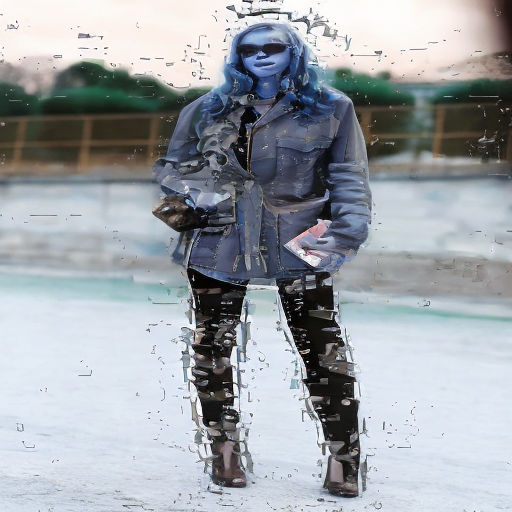

In [ ]:
from diffusers import StableDiffusionInpaintPipeline
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
)
pipe.to("cuda")
prompt = "Red color shoe, high resolution,"

image, mask_image = generate_input("/content/val_dataset/png_images/IMAGES/img_0003.png", "")


image = pipe(prompt=prompt, image=image, mask_image=mask_image).images[0]
image.resize((W_init, H_init))
# image.save("./shoe.png")
display(image)